# Set up

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTForImageClassification, TrainingArguments, Trainer, ViTImageProcessor, EarlyStoppingCallback, EvalPrediction
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from PIL import Image
import os
import io
import numpy as np
from matplotlib import pyplot as plt
import sys
import random
from collections import defaultdict
import glob

2025-11-11 22:38:02.871092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762900683.058356      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762900683.106868      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
PATHS_TO_PREVIEW = [
    ("Celeb-real", "/kaggle/input/deepfake-images/data/Celeb-real"),
    ("YouTube-real", "/kaggle/input/deepfake-images/data/YouTube-real"),
    ("Celeb-synthesis", "/kaggle/input/deepfake-images/data/Celeb-synthesis")
]

In [3]:
def preview_local_images(path_list):
    """
    Fetches and displays one sample image from each local path.
    path_list: list of tuples (label, path) or list of paths
    """
    num_paths = len(path_list)
    plt.figure(figsize=(15, 5))
    
    for i, item in enumerate(path_list):
        # Handle both tuple (label, path) and plain path
        if isinstance(item, tuple):
            label, path = item
        else:
            path = item
            label = os.path.basename(path)
        
        ax = plt.subplot(1, num_paths, i + 1)
        patterns_to_check = [".png", ".jpg", ".jpeg"]
        file_list = []
        
        for root, _, files in os.walk(path):
            for file in files:
                if any(file.lower().endswith(ext) for ext in patterns_to_check):
                    file_list.append(os.path.join(root, file))
        
        if not file_list:
            print(f"No image files found in {gcs_path}")
            continue
        
        sample_file_path = file_list[0]
        
        try:
            image = Image.open(sample_file_path).convert('RGB')
            ax.imshow(image)
            ax.set_title(f"Class: {label}\n{os.path.basename(sample_file_path)}")
            ax.axis('off')
        except Exception as e:
            print(f"Error loading image {sample_file_path}: {e}")
            ax.set_title(f"Error loading {label}")
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

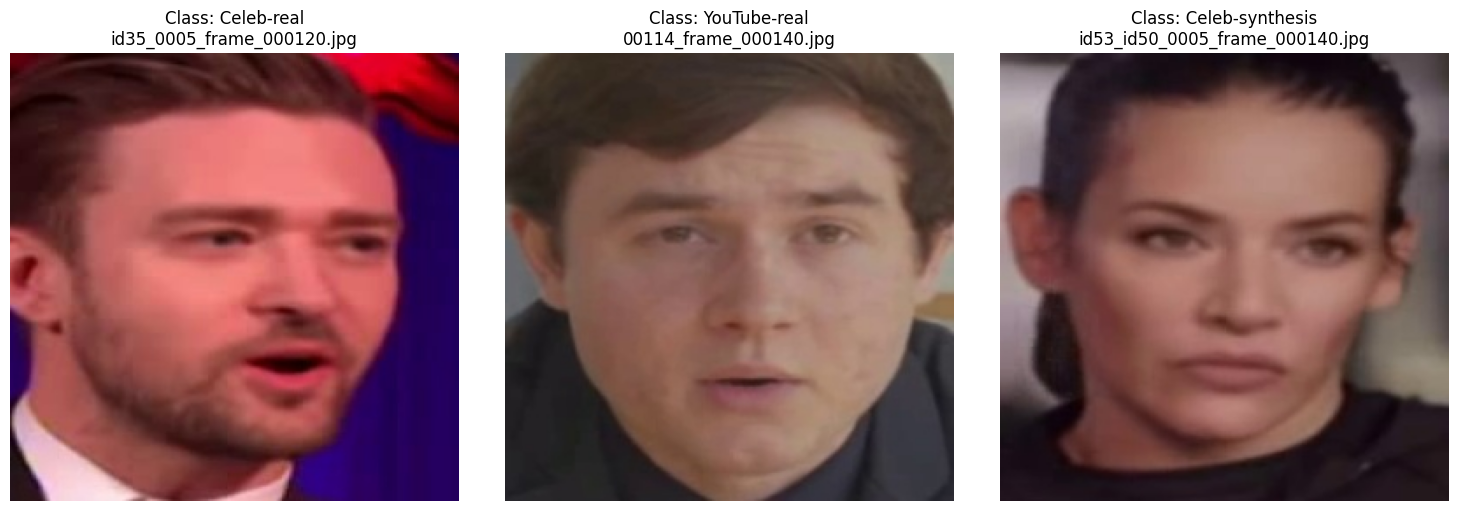

In [4]:
preview_local_images(PATHS_TO_PREVIEW)

# Image Preprocessing

In [5]:
class KaggleImageDataset(Dataset):
    """
    Custom PyTorch Dataset to load images directly from the local file system
    for use with HuggingFace Trainer.
    """
    def __init__(self, file_paths, labels, processor):
        self.file_paths = file_paths
        self.labels = labels
        self.processor = processor

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.file_paths)

    def __getitem__(self, idx):
        """
        Fetches the image from local path, applies processor, and returns
        the sample in HuggingFace format.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get the local path and label
        local_path = self.file_paths[idx]
        label = self.labels[idx]

        try:
            # Open the file from local path
            image = Image.open(local_path).convert('RGB')

            # Use the ViT processor
            processed = self.processor(images=image, return_tensors="pt")

            # Extract the pixel values and remove the batch dimension
            pixel_values = processed['pixel_values'].squeeze(0)

            # Return in HuggingFace format
            return {
                'pixel_values': pixel_values,
                'labels': torch.tensor(label, dtype=torch.long)
            }

        except Exception as e:
            print(f"Error loading image {local_path}: {e}")
            # Return a dummy sample if loading fails
            dummy_image = Image.new('RGB', (224, 224), color='black')
            processed = self.processor(images=dummy_image, return_tensors="pt")
            return {
                'pixel_values': processed['pixel_values'].squeeze(0),
                'labels': torch.tensor(0, dtype=torch.long)
            }

In [6]:
def get_data_split_by_folder(real_paths, fake_paths, model_name, random_seed):
    """
    Scans local directories, splits data BY FOLDER (video), creates datasets with ViT processor.
    This ensures frames from the same video don't leak between train/val/test sets.
    """
    
    patterns_to_check = ["*.png", "*.jpg", "*.jpeg"]
    
    # Dictionary to store files grouped by their parent folder (video)
    real_folders = defaultdict(list)
    fake_folders = defaultdict(list)
    
    # Get REAL image paths grouped by folder
    for path in real_paths:
        for ext in patterns_to_check:
            files = glob.glob(os.path.join(path, "**", ext), recursive=True)
            for file in files:
                # Get the parent folder name (video identifier)
                parent_folder = os.path.dirname(file)
                real_folders[parent_folder].append(file)
        
        print(f"Found {len(real_folders)} REAL folders in {path}")
        total_real_files = sum(len(files) for files in real_folders.values())
        print(f"  Total REAL images: {total_real_files}")
    
    # Get FAKE image paths grouped by folder
    for path in fake_paths:
        for ext in patterns_to_check:
            files = glob.glob(os.path.join(path, "**", ext), recursive=True)
            for file in files:
                # Get the parent folder name (video identifier)
                parent_folder = os.path.dirname(file)
                fake_folders[parent_folder].append(file)
        
        print(f"Found {len(fake_folders)} FAKE folders in {path}")
        total_fake_files = sum(len(files) for files in fake_folders.values())
        print(f"  Total FAKE images: {total_fake_files}")
    
    if len(real_folders) == 0 and len(fake_folders) == 0:
        raise ValueError("No images found in local paths. Check paths and permissions.")
    
    # Split REAL folders into train/val/test (70/15/15)
    real_folder_names = list(real_folders.keys())
    train_real_folders, temp_real_folders = train_test_split(
        real_folder_names, test_size=0.3, random_state=random_seed
    )
    val_real_folders, test_real_folders = train_test_split(
        temp_real_folders, test_size=0.5, random_state=random_seed
    )
    
    # Split FAKE folders into train/val/test (70/15/15)
    fake_folder_names = list(fake_folders.keys())
    train_fake_folders, temp_fake_folders = train_test_split(
        fake_folder_names, test_size=0.3, random_state=random_seed
    )
    val_fake_folders, test_fake_folders = train_test_split(
        temp_fake_folders, test_size=0.5, random_state=random_seed
    )
    
    # Collect files and labels for each split
    train_files, train_labels = [], []
    val_files, val_labels = [], []
    test_files, test_labels = [], []
    
    # Add REAL images to splits
    for folder in train_real_folders:
        train_files.extend(real_folders[folder])
        train_labels.extend([LABEL_REAL] * len(real_folders[folder]))
    
    for folder in val_real_folders:
        val_files.extend(real_folders[folder])
        val_labels.extend([LABEL_REAL] * len(real_folders[folder]))
    
    for folder in test_real_folders:
        test_files.extend(real_folders[folder])
        test_labels.extend([LABEL_REAL] * len(real_folders[folder]))
    
    # Add FAKE images to splits
    for folder in train_fake_folders:
        train_files.extend(fake_folders[folder])
        train_labels.extend([LABEL_FAKE] * len(fake_folders[folder]))
    
    for folder in val_fake_folders:
        val_files.extend(fake_folders[folder])
        val_labels.extend([LABEL_FAKE] * len(fake_folders[folder]))
    
    for folder in test_fake_folders:
        test_files.extend(fake_folders[folder])
        test_labels.extend([LABEL_FAKE] * len(fake_folders[folder]))
    
    # Print statistics
    print("\n" + "="*60)
    print("SPLIT BY FOLDER (VIDEO) - STATISTICS")
    print("="*60)
    print(f"Real folders: {len(real_folder_names)} total")
    print(f"  Train: {len(train_real_folders)} folders, {train_labels.count(LABEL_REAL)} images")
    print(f"  Val:   {len(val_real_folders)} folders, {val_labels.count(LABEL_REAL)} images")
    print(f"  Test:  {len(test_real_folders)} folders, {test_labels.count(LABEL_REAL)} images")
    print()
    print(f"Fake folders: {len(fake_folder_names)} total")
    print(f"  Train: {len(train_fake_folders)} folders, {train_labels.count(LABEL_FAKE)} images")
    print(f"  Val:   {len(val_fake_folders)} folders, {val_labels.count(LABEL_FAKE)} images")
    print(f"  Test:  {len(test_fake_folders)} folders, {test_labels.count(LABEL_FAKE)} images")
    print()
    print(f"TOTAL:")
    print(f"  Train: {len(train_files)} images ({len(train_real_folders) + len(train_fake_folders)} folders)")
    print(f"  Val:   {len(val_files)} images ({len(val_real_folders) + len(val_fake_folders)} folders)")
    print(f"  Test:  {len(test_files)} images ({len(test_real_folders) + len(test_fake_folders)} folders)")
    print("="*60)
    
    # Initialize ViT Image Processor
    processor = ViTImageProcessor.from_pretrained(model_name)
    
    # Create Datasets with the processor
    train_dataset = KaggleImageDataset(
        file_paths=train_files,
        labels=train_labels,
        processor=processor
    )
    val_dataset = KaggleImageDataset(
        file_paths=val_files,
        labels=val_labels,
        processor=processor
    )
    test_dataset = KaggleImageDataset(
        file_paths=test_files,
        labels=test_labels,
        processor=processor
    )
    
    return train_dataset, val_dataset, test_dataset, processor

In [7]:
def preprocess_logits_for_metrics(logits, labels):
    pred_ids = torch.argmax(logits, dim=-1)
    return pred_ids

In [8]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
    # Already converted to predictions, not logits
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary'
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [9]:
class MemoryEfficientTrainer(Trainer):
    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        """
        Override to return predictions instead of full logits
        """
        inputs = self._prepare_inputs(inputs)
        
        with torch.no_grad():
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits
        
        # Return predictions instead of logits to save memory
        if prediction_loss_only:
            return (loss, None, None)
        
        # Convert to predictions immediately
        preds = torch.argmax(logits, dim=-1)
        labels = inputs.get("labels")
        
        return (loss, preds, labels)

In [10]:
def attetion_rollout(attentions, discard_ratio=0.9):
    """
    Compute attention rollout from all transformer layers.
    Args:
        attentions: tuple of attention tensors from each layer
        discard_ratio: percentage of lowest attention values to discard
    Returns:
        Attention map for the [CLS] token
    """
    # Get device from first attention tensor
    device = attentions[0].device
    
    # Create identity matrix on the same device
    result = torch.eye(attentions[0].size(-1)).to(device)
    
    for attention in attentions:
        # Average across all heads
        attention_heads_fused = attention.mean(dim=1)
        attention_heads_fused = attention_heads_fused[0]
        
        # Drop the lowest attentions
        flat = attention_heads_fused.view(-1)
        _, indices = flat.topk(k=int(flat.size(-1) * discard_ratio), largest=False)
        flat[indices] = 0
        
        # Normalize
        I = torch.eye(attention_heads_fused.size(-1)).to(device)  # Fix: add .to(device)
        a = (attention_heads_fused + 1.0 * I) / 2
        a = a / a.sum(dim=-1, keepdim=True)
        result = torch.matmul(a, result)
    
    mask = result[0, 1:]
    return mask

In [11]:
def visualize_attention(model, image_path, processor, true_label=None):
    """
    Visualize attention rollout for a single image.
    
    Args:
        model: ViT model with output_attentions=True
        image_path: Path to local image file
        processor: ViTImageProcessor for preprocessing
        true_label: Optional true label (0 for FAKE, 1 for REAL, or string)
    """
    # Load image from local path
    image = Image.open(image_path).convert('RGB')
    
    # Process image
    inputs = processor(images=image, return_tensors="pt")
    
    # Move inputs to same device as model
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get model outputs with attentions
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    
    # Get attention weights
    attentions = outputs.attentions  # tuple of (num_layers) tensors
    
    # Compute attention rollout
    mask = attetion_rollout(attentions)
    
    # Reshape mask to image dimensions
    num_patches = int(mask.shape[0] ** 0.5)
    mask = mask.reshape(num_patches, num_patches).cpu().numpy()
    
    # Resize to original image size
    mask = Image.fromarray((mask * 255).astype(np.uint8)).resize(
        image.size, resample=Image.BILINEAR
    )
    mask = np.array(mask) / 255.0
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Attention heatmap
    axes[1].imshow(mask, cmap='jet')
    axes[1].set_title('Attention Rollout')
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(image)
    axes[2].imshow(mask, cmap='jet', alpha=0.5)
    axes[2].set_title('Overlay')
    axes[2].axis('off')
    
    # Get prediction
    prediction = outputs.logits.argmax(-1).item()
    pred_label = model.config.id2label[prediction]
    prob = torch.softmax(outputs.logits, dim=-1)[0][prediction].item()
    
    # Build title with prediction and true label
    title_parts = [f'Prediction: {pred_label} ({prob:.2%})']
    
    if true_label is not None:
        # Convert true_label to string if it's numeric
        if isinstance(true_label, (int, np.integer)):
            true_label_str = model.config.id2label[true_label]
        else:
            true_label_str = true_label
        
        # Check if prediction is correct
        is_correct = (pred_label == true_label_str)
        correctness = "✓" if is_correct else "✗"
        
        title_parts.append(f'True Label: {true_label_str} {correctness}')
    
    fig.suptitle(' | '.join(title_parts), fontsize=16)
    
    plt.tight_layout()
    plt.show()
    
    return mask

In [12]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [13]:
# Define Parameters and Input
REAL_PATHS = [
    "/kaggle/input/deepfake-images/data/Celeb-real",
    "/kaggle/input/deepfake-images/data/YouTube-real"
]
FAKE_PATHS = [
    "/kaggle/input/deepfake-images/data/Celeb-synthesis"
]

LABEL_REAL = 0
LABEL_FAKE = 1

IMG_SIZE = 224
BATCH_SIZE = 16
RANDOM_SEED = 42
EPOCHS = 10
LEARNING_RATE = 2e-5

model_name = "google/vit-base-patch16-224"

In [14]:
seed_everything(RANDOM_SEED)

In [16]:
# Get the data
train_dataset, val_dataset, test_dataset, processor = get_data_split_by_folder(
    REAL_PATHS, FAKE_PATHS, model_name, random_seed = RANDOM_SEED
)

Found 590 REAL folders in /kaggle/input/deepfake-images/data/Celeb-real
  Total REAL images: 11536
Found 890 REAL folders in /kaggle/input/deepfake-images/data/YouTube-real
  Total REAL images: 18352
Found 2361 FAKE folders in /kaggle/input/deepfake-images/data/Celeb-synthesis
  Total FAKE images: 45228

SPLIT BY FOLDER (VIDEO) - STATISTICS
Real folders: 890 total
  Train: 623 folders, 12771 images
  Val:   133 folders, 2739 images
  Test:  134 folders, 2842 images

Fake folders: 2361 total
  Train: 1652 folders, 31822 images
  Val:   354 folders, 6695 images
  Test:  355 folders, 6711 images

TOTAL:
  Train: 44593 images (2275 folders)
  Val:   9434 images (487 folders)
  Test:  9553 images (489 folders)


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

# Modeling

In [17]:
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels = 2,
    id2label = {0: "FAKE", 1: "REAL"},
    label2id = {"FAKE": 0, "REAL": 1},
    ignore_mismatched_sizes = True,
    output_attentions = True
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
for param in model.vit.embeddings.parameters():
    param.requires_grad = False

In [19]:
# Freeze all encoder layers except the last 2
num_layers = len(model.vit.encoder.layer)
for i, layer in enumerate(model.vit.encoder.layer):
    if i < num_layers - 2:  # Freeze all but last 2 layers
        for param in layer.parameters():
            param.requires_grad = False

In [20]:
for param in model.vit.layernorm.parameters():
    param.requires_grad = True

In [21]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,} / {total_params:,} ({100 * trainable_params / total_params:.2f}%)")

Trainable parameters: 14,178,818 / 85,800,194 (16.53%)


In [22]:
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience = 3,
    early_stopping_threshold = 0.01 
)

In [23]:
training_args = TrainingArguments(
    output_dir = "./vit-fake-detector",
    per_device_train_batch_size = BATCH_SIZE,
    per_device_eval_batch_size = 8,
    num_train_epochs = EPOCHS,
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate = LEARNING_RATE,
    weight_decay = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = "f1",
    greater_is_better = True,
    logging_dir = './logs',
    logging_steps = 100,
    remove_unused_columns = False,
    push_to_hub = False,
    report_to = "none",
    save_total_limit = 2,
    dataloader_pin_memory = False
)

In [24]:
trainer = MemoryEfficientTrainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    compute_metrics = compute_metrics,
    callbacks = [early_stopping_callback]
)

In [25]:
import gc
torch.cuda.empty_cache()
gc.collect()

6857

In [26]:
trainer.train()

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
test_results = trainer.evaluate(test_dataset)
print(f"Test results: {test_results}")

In [27]:
processor = ViTImageProcessor.from_pretrained(model_name)

In [28]:
best_model = trainer.model

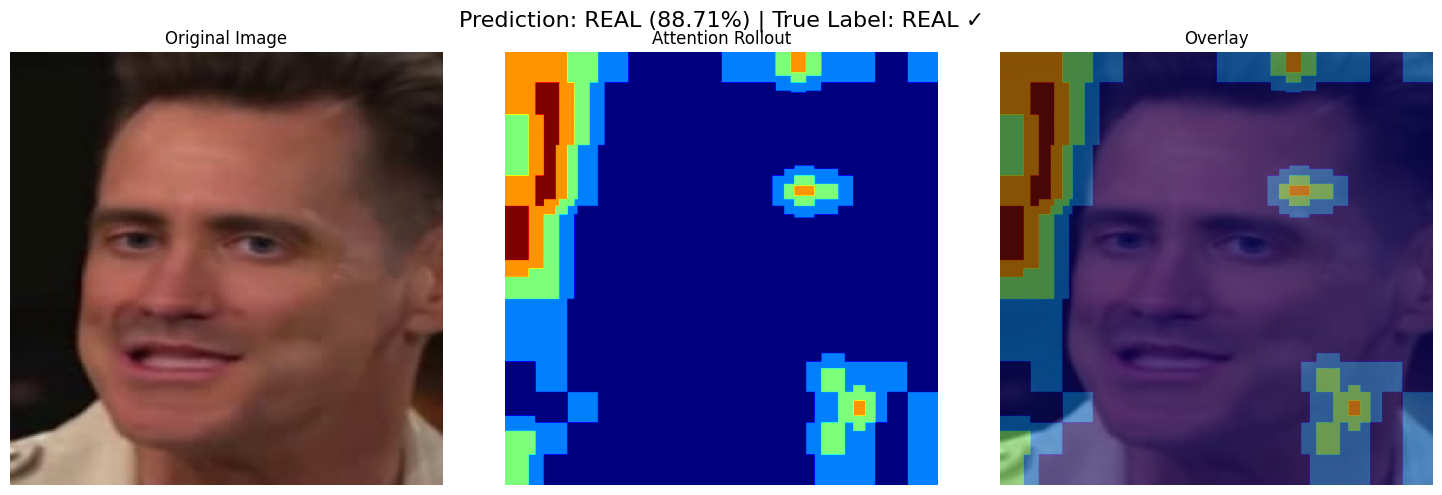

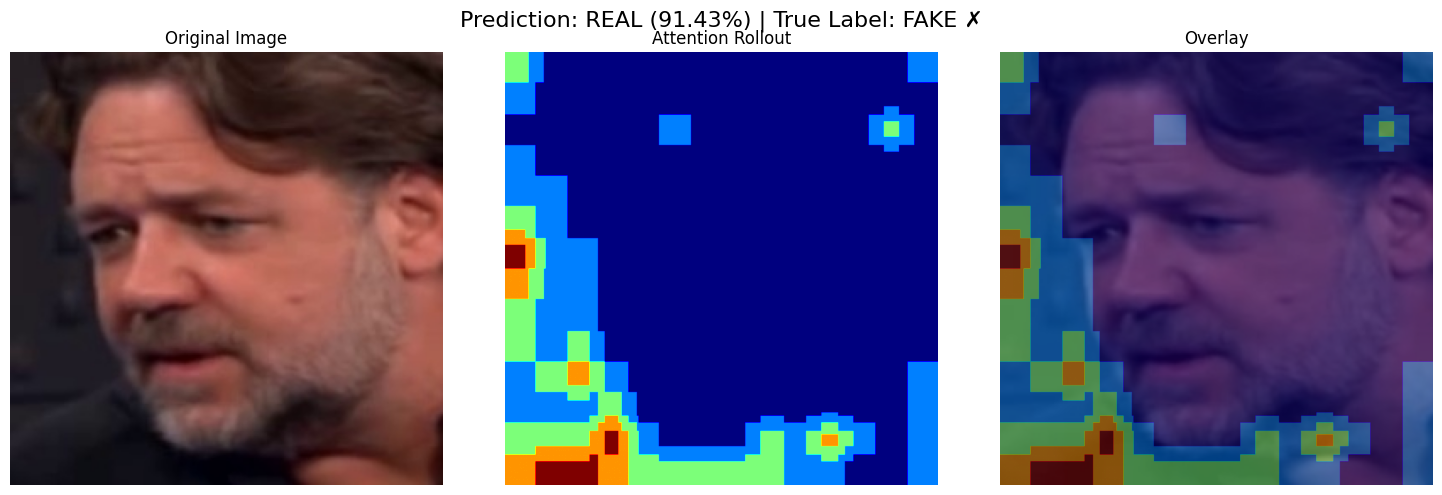

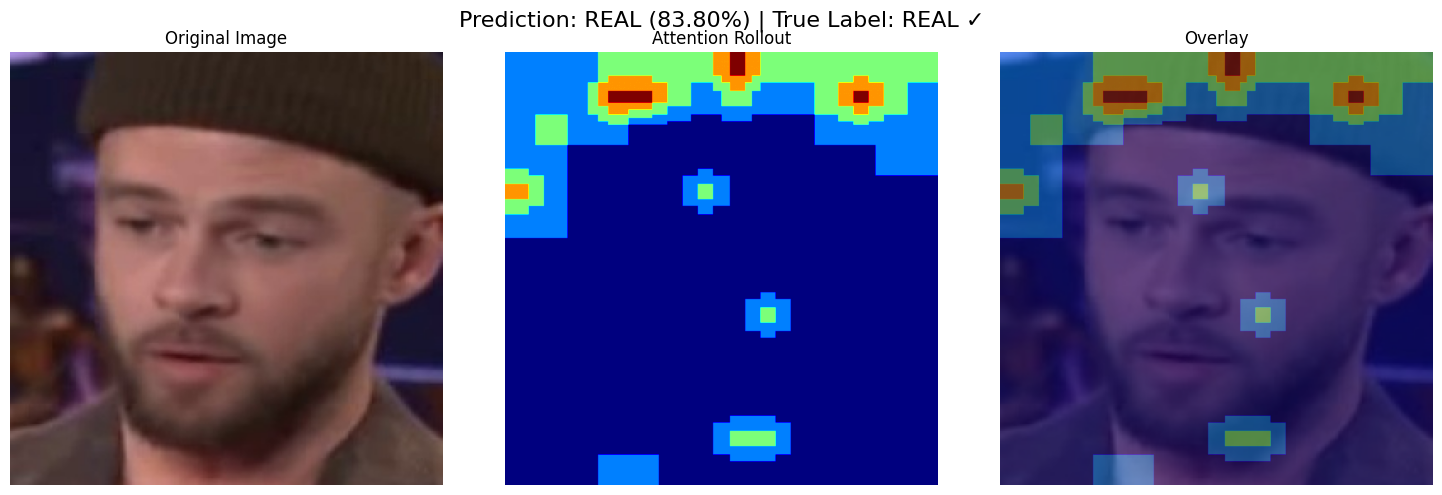

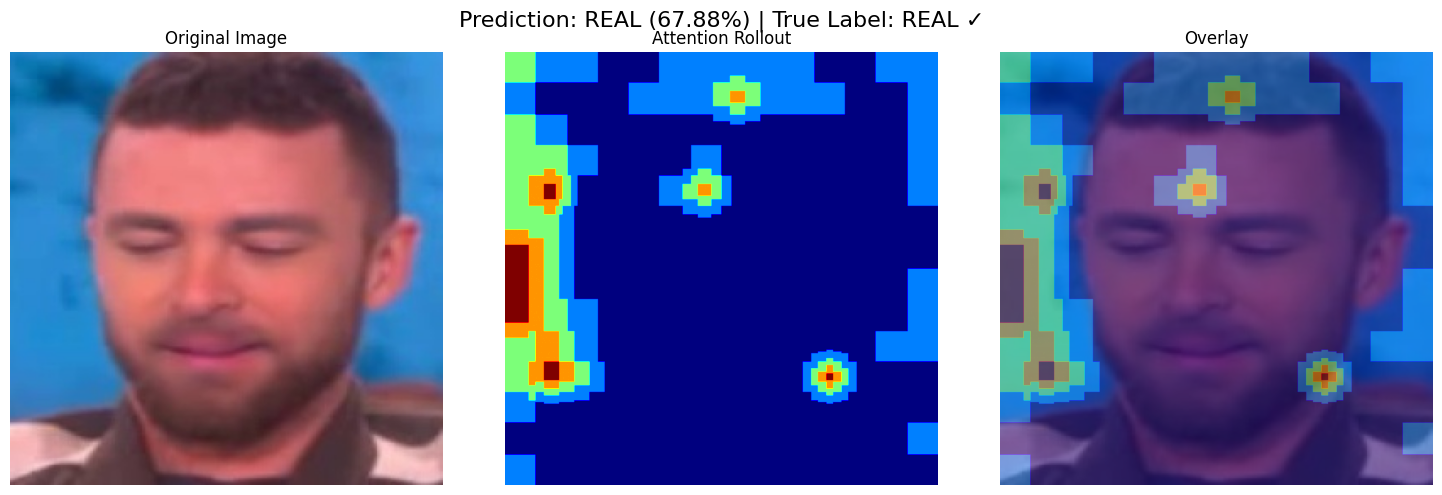

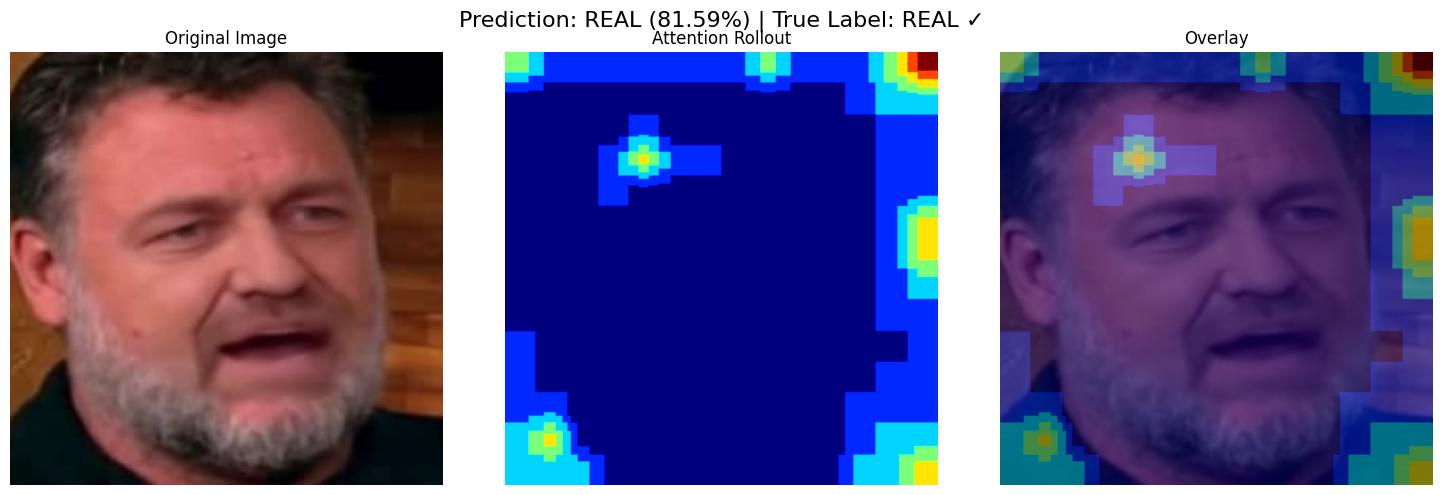

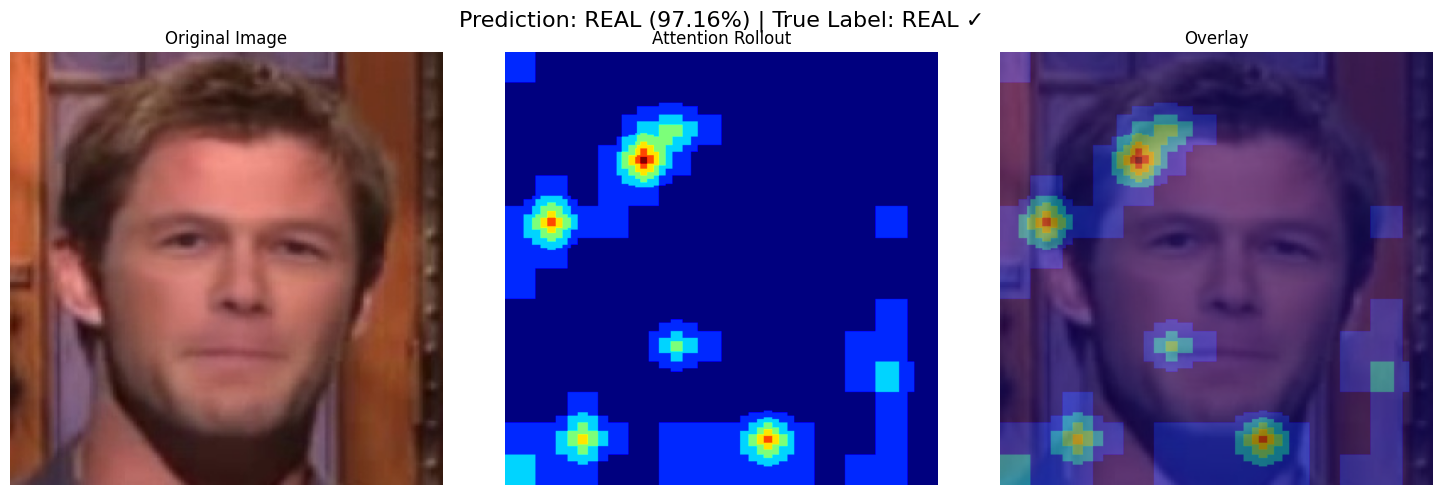

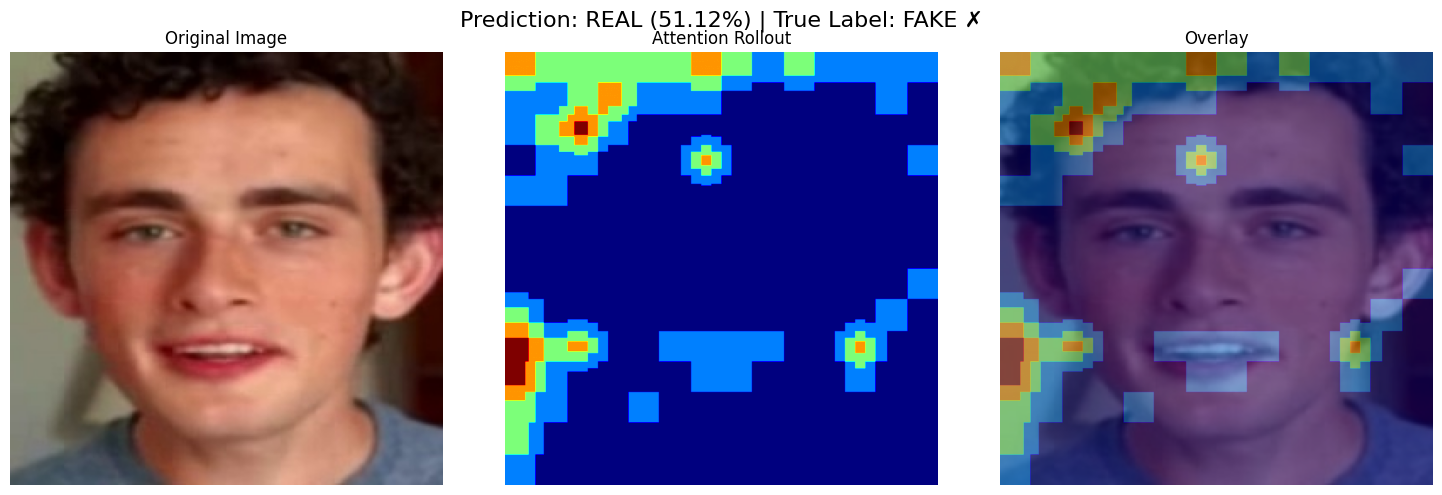

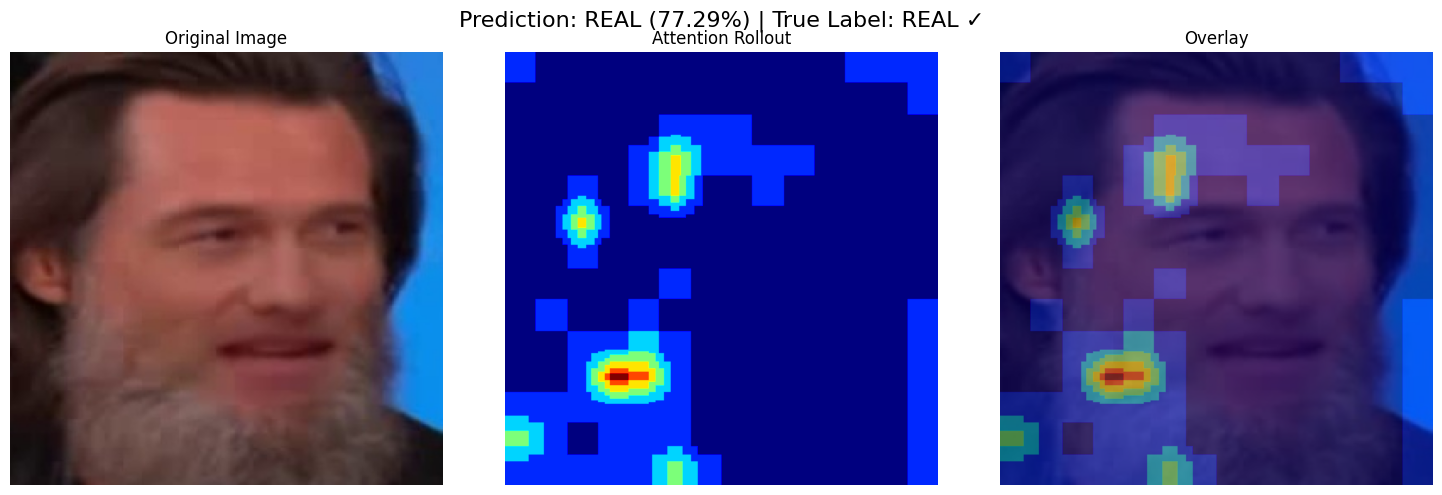

In [ ]:
tmp = np.random.randint(0, len(test_dataset.file_paths), 10)

for idx in tmp:
    image_path = test_dataset.file_paths[idx]
    true_label = test_dataset.labels[idx]
    visualize_attention(best_model, image_path, processor, true_label = true_label)

In [ ]:
tmp = np.random.randint(0, len(test_dataset.file_paths), 10)

for idx in tmp:
    image_path = test_dataset.file_paths[idx]
    true_label = test_dataset.labels[idx]
    visualize_attention(best_model, image_path, processor, true_label = true_label)

In [ ]:
tmp = np.random.randint(0, len(test_dataset.file_paths), 10)

for idx in tmp:
    image_path = test_dataset.file_paths[idx]
    true_label = test_dataset.labels[idx]
    visualize_attention(best_model, image_path, processor, true_label = true_label)